# Day 4: Demand I - Enhancing the model with demand

We will continue our modeling exercise by adding carbon taxes, renewable subsidies, and investment to the model.

This will allow us to consider the policy impacts of alternative energy transition policies.

The data and code are based on the paper "The Efficiency and Sectoral Distributional Implications of Large-Scale Renewable Policies," by Mar Reguant.

We first load relevant libraries, same as last session.

In [1]:
using Pkg
Pkg.add(["DataFrames", "CSV", "JuMP", "Ipopt", "Cbc", "Plots", "Printf"])

    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [5]:
begin 
    using DataFrames
    using CSV
    using JuMP
    using Ipopt, Cbc
    using Plots
    using Printf
end

Remember to set your path correctly:

In [10]:
dirpath = "/Users/marreguant/Documents/GitHub/em-course/materials/day4/"

"/Users/marreguant/Documents/GitHub/em-course/materials/day4/"

## Building the model

We load the same data as usual, and also clean it up to simplify it further and create the demand and import curves.

In [11]:
begin
    dfclust = CSV.read(string(dirpath,"data_jaere_clustered.csv"), DataFrame);

    # Re-scaling (we multiply by 8.76 to make it into a full year of hours (divided by 1000))
    dfclust.weights = 8.76 * dfclust.weights / sum(dfclust.weights);

    # Here only one demand type to make it easier
    dfclust.demand = dfclust.q_residential + dfclust.q_commercial + dfclust.q_industrial;

    # Calibrate imports (using elas 0.3)
    dfclust.bm = 0.3 * dfclust.imports ./ dfclust.price;  # slope
    dfclust.am = dfclust.imports - dfclust.bm .* dfclust.price;  # intercept
    
    describe(dfclust)
end

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,price,38.5055,1.66311,37.2797,137.116,0,Float64
2,imports,7.52426,4.2479,7.57055,9.79814,0,Float64
3,q_commercial,12.9532,9.26236,12.3881,22.1766,0,Float64
4,q_industrial,4.1224,2.60049,3.83347,7.62003,0,Float64
5,q_residential,11.0753,4.3995,10.0075,20.4922,0,Float64
6,wind_cap,0.340955,0.0935896,0.334676,0.681777,0,Float64
7,solar_cap,0.260549,0.00155919,0.0679638,0.793407,0,Float64
8,hydronuc,5.0346,2.36316,4.56859,9.68051,0,Float64
9,weights,0.0876,0.00787044,0.0788053,0.227839,0,Float64


The technology file now includes the fixed cost of building new power plants (technologies 3-5). Note that we added an additional row for new natural gas plants.

We will use an annualization factor to pro-rate the importance of fixed costs for one year.

In [12]:
begin
    tech = CSV.read(string(dirpath,"data_technology.csv"), DataFrame);
    afactor = (1 - (1 / (1.05^20.0))) / 0.05;
    tech.F = tech.F ./afactor;
    tech.F2 = tech.F2 ./afactor;
    tech
end

,techname,heatrate,heatrate2,F,capLB,capUB,new,renewable
,String15,Float64,Float64,Float64,Float64,Float64,Int64,Int64
1,Hydro/Nuclear,10.0,0.0,0.0,1.0,1.0,0,0
2,Existing 1,6.67199,0.0929123,0.0,11.5,11.5,0,0
3,Existing 2,9.79412,0.286247,0.0,14.5,14.5,0,0
4,Existing 3,13.8181,20.5352,0.0,0.578,0.578,0,0
5,New Gas,6.6,0.0,78.4773,0.0,100.0,1,0
6,Wind,0.0,0.0,100.303,0.0,100.0,1,1
7,Solar,0.0,0.0,100.303,0.0,100.0,1,1


### Adding demand considerations

We are now ready to clear the market. We will **maximize welfare** using a non-linear solver.

$$ \max \ CS - Costs - Fixed Costs \\

\text{s.t.} \ \text{operational constraints, market clearing}. $$

To include demand, we will separate the price that consumers pay from the price that the wholesale market sets. We define a variable "tariff" that is what consumers pay any hour of the day.

We also allow alpha to determine the share of "insensitive" consumers. We can see how the investment changes as we modify "alpha".

In [13]:
## Clear market based on cost minimization
function clear_market_invest_tariff(data::DataFrame, tech::DataFrame; 
        tariff=35.0, alpha=1.0, tax=0.0, subsidy=0.0, ng_price = 4.0, elas = 0.3)

    # We declare a model
    model = Model(
        optimizer_with_attributes(
            Ipopt.Optimizer, 
                "print_level"=>0)
        );

    # Set useful indexes
    I = nrow(tech);  # number of techs
    T = nrow(data);  # number of periods

    for i = 2:5
        tech.c[i] = tech.heatrate[i] * ng_price;
        tech.c2[i] = tech.heatrate2[i] * ng_price;
    end
    
    # Setting demand parameters
    data.b = elas * data.demand ./ data.price;  # slope
    data.a = data.demand + data.b .* data.price;  # intercept
    
    # Variables to solve for
    @variable(model, price[1:T]);
    @variable(model, demand[1:T]);
    @variable(model, imports[1:T]);
    @variable(model, quantity[1:T, 1:I] >= 0.0);
    @variable(model, costs[1:T]);
    @variable(model, total_cost);
    @variable(model, gross_surplus[1:T]);
    @variable(model, 0.0 <= gas_gw <= 100.0);
    @variable(model, 0.0 <= wind_gw <= 100.0);
    @variable(model, 0.0 <= solar_gw <= 100.0);

    # Maximize welfare including imports costs
    @NLobjective(model, Max, sum(data.weights[t] * gross_surplus[t] for t=1:T) - total_cost);

    # Market clearing
    @constraint(model, [t=1:T], 
        demand[t] == data.a[t] - data.b[t] * (alpha*tariff + (1.0-alpha)*price[t]));
    @constraint(model, [t=1:T], 
        imports[t] == data.am[t] + data.bm[t] * price[t]);
    @constraint(model, [t=1:T], 
        demand[t] == sum(quantity[t,i] for i=1:I) + imports[t]);

    # Define surplus
    data.ahat = data.a - alpha * data.b * tariff - data.am;
    data.bhat = (1.0-alpha)*data.b + data.bm; 
    @constraint(model, [t=1:T], gross_surplus[t]==
        # demand after accounting for imports and insensitive consumers
            (price[t] * (data.ahat[t] - data.bhat[t]*price[t]) + (data.ahat[t] - data.bhat[t]*price[t])^2/(2*data.bhat[t])));

    # Define costs
    @NLconstraint(model, [t=1:T], costs[t] ==
                    sum(tech.c[i] * quantity[t,i] +
                    tech.c2[i] * quantity[t,i]^2/2 +
                    tax * tech.e[i] * quantity[t,i] -
                    subsidy * tech.renewable[i] * quantity[t,i] for i=1:I));
    @NLconstraint(model, total_cost == sum(data.weights[t] * costs[t] for t=1:T) + 
             tech.F[5]*gas_gw  + tech.F[6]*wind_gw + tech.F[7]*solar_gw);

    # Constraints on output
    @constraint(model, [t=1:T], 
        quantity[t,1] <= data.hydronuc[t]);
    @constraint(model, [t=1:T,i=2:4], 
        quantity[t,i] <= tech[i,"capUB"]);
    @constraint(model, [t=1:T], 
        quantity[t,5] <= gas_gw);
    @constraint(model, [t=1:T], 
        quantity[t,6] <= wind_gw * data.wind_cap[t]);
    @constraint(model, [t=1:T], 
        quantity[t,7] <= solar_gw * data.solar_cap[t]);
             
    # Solve model
    optimize!(model);

    status = @sprintf("%s", JuMP.termination_status(model));

    if (status=="LOCALLY_SOLVED")
        p = JuMP.value.(price);
        d = JuMP.value.(demand);
        d_insen = (data.a .- data.b.*tariff);
        d_sen = (data.a .- data.b.*p);
        avg_price = sum(p.*d.*data.weights)/sum(d.*data.weights);
        avg_price_insen = sum(p.*d_insen.*data.weights)/sum(d_insen.*data.weights);
        avg_price_sen = sum(p.*d_sen.*data.weights)/sum(d_sen.*data.weights);
        imp = JuMP.value.(imports);
        q = JuMP.value.(quantity);
        cost = JuMP.value.(costs);
        results = Dict("status" => @sprintf("%s",JuMP.termination_status(model)),
            "avg_price" => avg_price,
            "avg_price_insen" => avg_price_insen,
            "avg_price_sen" => avg_price_sen,
            "price" => p,
            "quantity" => q,
            "imports" => imp,
            "demand" => d,
            "cost" => cost,
            "total_cost" => JuMP.value.(total_cost),
            "gas_gw" => JuMP.value.(gas_gw),
            "wind_gw" => JuMP.value.(wind_gw),
            "solar_gw" => JuMP.value.(solar_gw),
            "welfare" => objective_value(model));
        return results
    else
        results = Dict("status" => @sprintf("%s",JuMP.termination_status(model)));
        @printf("Solving error!")
        return results
    end

end

clear_market_invest_tariff (generic function with 1 method)

We will set the initial tariff to $35/MWh.

In [14]:
results1 = clear_market_invest_tariff(dfclust, tech, tariff=35.0, alpha=1.0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



Dict{String, Any} with 14 entries:
  "avg_price"       => 41.9207
  "price"           => [46.7349, 30.888, 29.3978, 42.8286, 30.205, 30.1481, 30.…
  "gas_gw"          => 4.44261
  "status"          => "LOCALLY_SOLVED"
  "quantity"        => [9.46003 11.5 … 3.34339e-8 2.58524e-9; 4.0713 11.301 … 2…
  "solar_gw"        => -9.91207e-9
  "imports"         => [9.01364, 7.83199, 8.18451, 7.17327, 5.81939, 7.30439, 8…
  "avg_price_sen"   => 22.3446
  "demand"          => [41.0176, 27.647, 26.6268, 29.9942, 22.5644, 24.0404, 25…
  "welfare"         => 33758.0
  "avg_price_insen" => 41.9207
  "cost"            => [826.934, 483.332, 388.84, 616.442, 414.873, 411.695, 42…
  "total_cost"      => 4455.31
  "wind_gw"         => 7.69907e-8

Notice that average weighted prices are higher than the tariff we charged consumers, we need to charge them more or otherwise, we would not be able to pay the producers of energy.

In [15]:
results2 = clear_market_invest_tariff(dfclust, tech, tariff=50.0, alpha=1.0)

Dict{String, Any} with 14 entries:
  "avg_price"       => 49.3583
  "price"           => [46.5458, 30.6732, 29.111, 41.8348, 30.3265, 29.6282, 29…
  "gas_gw"          => 1.43484
  "status"          => "LOCALLY_SOLVED"
  "quantity"        => [9.46003 11.5 … 1.24713e-8 2.62222e-9; 4.0713 10.723 … 1…
  "solar_gw"        => -9.9109e-9
  "imports"         => [9.0036, 7.81694, 8.16211, 7.11544, 5.82542, 7.26339, 8.…
  "avg_price_sen"   => 7.23437
  "demand"          => [37.8346, 24.0461, 22.8249, 26.0606, 19.8897, 19.5926, 2…
  "welfare"         => 25318.3
  "avg_price_insen" => 49.3583
  "cost"            => [739.827, 386.134, 286.856, 500.296, 345.364, 290.476, 3…
  "total_cost"      => 3433.89
  "wind_gw"         => 1.09296e-8

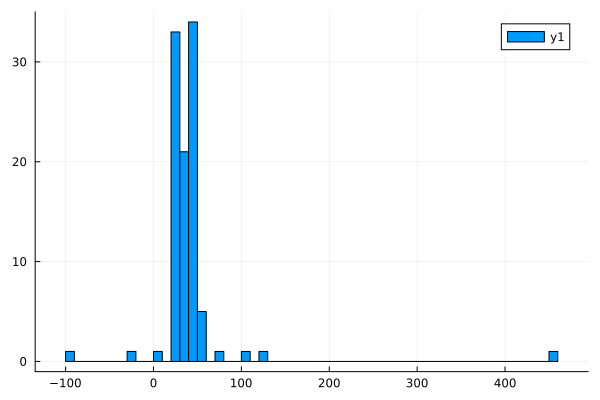

In [16]:
histogram(results1["price"])

We can see the right tariff is between \\$35 and \\$50/MWh.

### Solving for the fixed point
We can solve for the fixed point in a loop.

In [17]:
let
    current_diff = 1.0;
    guess = 47.0;
    while (current_diff > 1e-2)
        res = clear_market_invest_tariff(dfclust, tech, tariff=guess);
        newguess = res["avg_price_insen"];
        current_diff = (guess-newguess).^2;
        guess = newguess;
    end
    guess
end

47.94013355615169

Note: It is best to convert this into a function so that now we can compare alternative solutions.

In [18]:
function clear_market_equilibrium(data::DataFrame, tech::DataFrame; 
        tariff=35.0, alpha=1.0, tax=0.0, subsidy=0.0, ng_price = 4.0, elas = 0.1)
    
    current_diff = 1.0;
    guess = tariff;
    while (current_diff > 1e-3)
        res = clear_market_invest_tariff(dfclust, tech, tariff=guess, alpha=alpha,
            tax=tax, subsidy=subsidy, ng_price=ng_price, elas=elas);
        newguess = res["avg_price_insen"];
        current_diff = (guess-newguess).^2;
        guess = 0.5*newguess + 0.5*guess;
    end
    
    # we solve at the equilibrium guess and save tariff
    res = clear_market_invest_tariff(dfclust, tech, tariff=guess, alpha=alpha,
            tax=tax, subsidy=subsidy, ng_price=ng_price);
    res["tariff"] = guess;
    
    return res
    
end

clear_market_equilibrium (generic function with 1 method)

In [19]:
res_sen = clear_market_equilibrium(dfclust, tech, alpha=0.0, tariff=43.0, elas=0.1)

Dict{String, Any} with 15 entries:
  "avg_price"       => 36.3463
  "price"           => [45.5722, 37.1894, 30.2535, 42.0858, 30.8975, 31.254, 30…
  "gas_gw"          => 3.27641
  "status"          => "LOCALLY_SOLVED"
  "quantity"        => [9.46003 11.5 … 4.50417e-8 2.56083e-9; 4.0713 11.5 … 3.8…
  "solar_gw"        => -9.92085e-9
  "tariff"          => 36.7052
  "imports"         => [8.95188, 8.27364, 8.25133, 7.13004, 5.85378, 7.39157, 8…
  "avg_price_sen"   => 36.3463
  "demand"          => [38.7742, 27.1214, 27.8299, 28.136, 23.296, 25.1512, 26.…
  "welfare"         => 7876.01
  "avg_price_insen" => 38.0774
  "cost"            => [749.281, 458.697, 426.724, 558.111, 441.013, 447.816, 4…
  "total_cost"      => 4376.65
  "wind_gw"         => 1.13637e-7

In [20]:
res_insen = clear_market_equilibrium(dfclust, tech, alpha=1.0, tariff=43.0, elas=0.1)

Dict{String, Any} with 15 entries:
  "avg_price"       => 42.6267
  "price"           => [46.71, 30.8602, 29.3608, 42.7005, 30.2204, 30.0812, 30.…
  "gas_gw"          => 4.05734
  "status"          => "LOCALLY_SOLVED"
  "quantity"        => [9.46003 11.5 … 2.96888e-8 2.58588e-9; 4.0713 11.2264 … …
  "solar_gw"        => -9.91152e-9
  "tariff"          => 36.9241
  "imports"         => [9.01232, 7.83005, 8.18162, 7.16581, 5.82015, 7.29911, 8…
  "avg_price_sen"   => 20.7045
  "demand"          => [40.6093, 27.1851, 26.1391, 29.4896, 22.2213, 23.4699, 2…
  "welfare"         => 32585.7
  "avg_price_insen" => 42.6267
  "cost"            => [815.749, 470.855, 375.745, 601.488, 405.953, 396.103, 4…
  "total_cost"      => 4322.53
  "wind_gw"         => 6.51929e-8

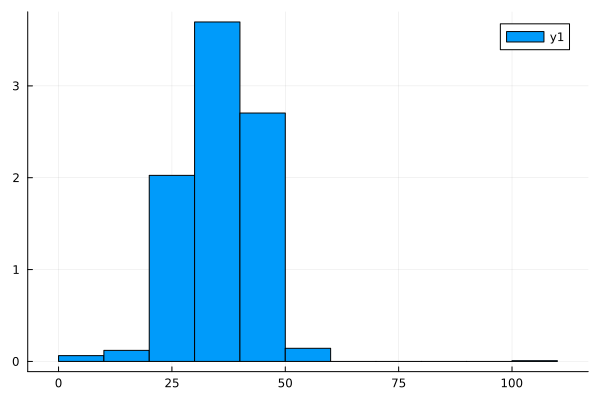

In [21]:
histogram(res_sen["price"], weights=dfclust.weights)

## Does it help to have attentive consumers?

We visualize the impact of the policy.

We can plot the costs (or prices) of electricity for several values of alpha. This can take a while to compute.

In [22]:
begin
    
    share_alpha = collect(0.1:0.2:0.9);
    tax = collect(0.0:15.0:30.0);
    
    dataPolicy = DataFrame(alpha=Float64[], tax=Float64[], tariff=Float64[], wind_gw=Float64[], solar_gw=Float64[]);
    
    for a in share_alpha
        for t in tax
            res = clear_market_equilibrium(dfclust, tech, 
                tariff=40.0, alpha=a, tax=t, elas=0.3);
            push!(dataPolicy, [a, t, res["tariff"], res["wind_gw"], res["solar_gw"]]);
        end
    end
    
end

In [68]:
dataPolicy

,alpha,tax,tariff,total_cost,wind_gw
,Float64,Float64,Float64,Float64,Float64
1,0.1,0.0,38.3539,4360.26,9.58263e-8
2,0.1,15.0,40.9121,4674.65,18.1436
3,0.1,30.0,42.7318,4846.09,24.2261
4,0.3,0.0,38.7378,4319.29,7.80001e-8
5,0.3,15.0,41.4447,4614.03,17.3668
6,0.3,30.0,43.4604,4778.98,22.8412
7,0.5,0.0,39.333,4258.55,7.90776e-8
8,0.5,15.0,42.4177,4528.7,16.1888
9,0.5,30.0,44.7032,4680.28,20.8437


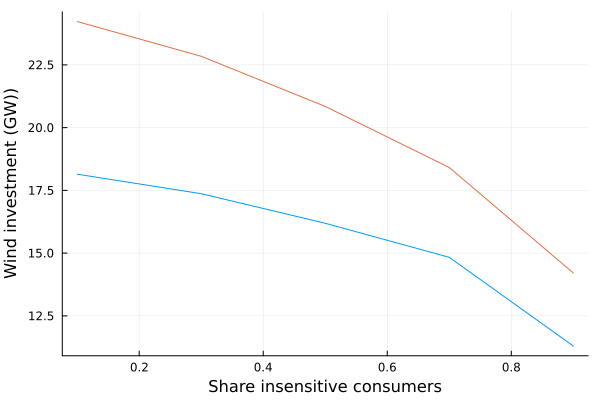

In [70]:
let
    
    tax1 = dataPolicy[dataPolicy.tax.==15.0,:]
    tax2 = dataPolicy[dataPolicy.tax.==30.0,:]
    
    plot(tax1.alpha, tax1.wind_gw, legend = false)
    plot!(tax2.alpha, tax2.wind_gw, legend = false)
    plot!(xlab="Share insensitive consumers",ylab="Wind investment (GW))")
    
end

## Follow-up exercises

1. What take aways do you get from the above visualization?

2. Consider an energy savings technology. How could it be added to the model? What would be the challenges in calibrating it?